In [118]:
#Imports
from math import log, sqrt, pi, exp
from scipy.stats import norm
import pandas as pd
import tensorflow as tf
import numpy as np

def read_file(file):
    """Read a single file and return a dataframe"""
    return pd.read_csv(file, skipinitialspace=True)

In [119]:
# Black-Scholes formula for call options
def d1(S,K,T,r,sigma):
    x1 = S.apply(lambda x : log(x)) - K.apply(lambda x : log(x))
    x2 = (r + ((sigma.apply(lambda x : x**2)) / 2)) * T
    x3 = sigma * T.apply(lambda x: sqrt(x))
    return  (x1 + x2) / x3

def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma) - sigma * T.apply(lambda x : sqrt(x))  

def bs_call(S,K,T,r,sigma):
    T = T/365
    r = r/100
    return S * d1(S,K,T,r,sigma).apply(lambda x : norm.cdf(x)) - K * (-r*T).apply(lambda x : exp(x)) * d2(S,K,T,r,sigma).apply(lambda x : norm.cdf(x))

In [120]:
#Insert file with LSTM predictions
df_options = read_file("data/12-08_10-04_LSTM_2021_combined.csv")
#Calculating BS and add column
df_options["B-S"] = bs_call(df_options["Underlying_last"], df_options["Strike"], df_options["Ttl"], df_options["R"], df_options["Volatility"])
#Cleaning
df_options = df_options[["Quote_date", "Underlying_last", "Strike", "Ttl", "Volatility", "R", "Price", "B-S", "Prediction"]]
df_options_LSTM = df_options.rename(columns={"Prediction":"LSTM"})


#MLP
df_options = read_file("data/12-08_12-10_MLP_2021_combined.csv")
df_options_MLP = df_options["MLP Prediction"]
df_options_MLP = df_options.rename(columns={"MLP Prediction":"MLP"})


FileNotFoundError: [Errno 2] No such file or directory: 'data/12-08_10-04_LSTM_2021_combined.csv'

In [ ]:
df_options = pd.concat([df_options_LSTM, df_options_MLP["MLP"]], axis = 1)

In [189]:
df_options = read_file("all_predictions.csv")

In [190]:
df_options_backup = df_options

In [191]:
df_options.head()

,Quote_date,Underlying_last,Strike,Ttl,Volatility,R,Price,BS,LSTM,MLP
0,2021-01-04,3701.38,1000.0,2,0.185353,0.09,2701.855,2701.384931,2714.8896,2692.4382
1,2021-01-05,3727.05,1000.0,1,0.184968,0.08,2726.195,2727.052192,2731.6880,2717.7556
2,2021-01-04,3701.38,1100.0,2,0.185353,0.09,2598.795,2601.385425,2615.4146,2593.0208
3,2021-01-05,3727.05,1100.0,1,0.184968,0.08,2626.705,2627.052411,2632.6520,2618.3533
4,2021-01-04,3701.38,1200.0,2,0.185353,0.09,2500.195,2501.385918,2515.3680,2493.7195


Creating table

In [ ]:
df_low_money = df_options[df_options["Underlying_last"] / df_options["Strike"] < 0.97]
df_low_money.name = "<0.97"
df_mid_money = df_options[(df_options["Underlying_last"] / df_options["Strike"]).between(0.97, 1.03, inclusive=True)]
df_mid_money.name = "0.97-1.03"
df_high_money = df_options[df_options["Underlying_last"] / df_options["Strike"] > 1.03]
df_high_money.name = ">1.03"

/Users/hjalmarvinje/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#RMSE
df_RMSE = pd.DataFrame(columns=['Moneyness', 'Maturity', 'BS', 'MPL', 'LSTM'])
for dataframex in [df_low_money, df_mid_money, df_high_money]:
    i = 1
    for days in [89,89,89,179,179,454]:
        df_temp = dataframex[(df_options["Ttl"]).between(i, i + days, inclusive=True)]
        bs = sqrt(tf.keras.metrics.mean_squared_error(df_temp["Price"], df_temp["B-S"]))
        mlp = sqrt(tf.keras.metrics.mean_squared_error(df_temp["Price"], df_temp["MLP"]))
        lstm = sqrt(tf.keras.metrics.mean_squared_error(df_temp["Price"], df_temp["LSTM"]))
        df_RMSE.loc[len(df_RMSE.index)] = [dataframex.name, str(i) + "-" + str(i + days), bs, mlp, lstm]
        i = i + days + 1 

with open('2021_results_RMSE.tex', 'w') as tf:
     tf.write(df_RMSE.round(2).to_latex(index=False))


/Users/hjalmarvinje/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  
/Users/hjalmarvinje/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [ ]:
import tensorflow as tf
#MAE
df_MAE = pd.DataFrame(columns=['Moneyness', 'Maturity', 'BS', 'MPL', 'LSTM'])
for dataframex in [df_low_money, df_mid_money, df_high_money]:
    i = 1
    for days in [89,89,89,179,179,454]:
        df_temp = dataframex[(df_options["Ttl"]).between(i, i + days, inclusive=True)]
        bs = (tf.keras.metrics.mean_absolute_error(df_temp["Price"], df_temp["B-S"])).numpy()
        mlp = (tf.keras.metrics.mean_absolute_error(df_temp["Price"], df_temp["MLP"])).numpy()
        lstm = (tf.keras.metrics.mean_absolute_error(df_temp["Price"], df_temp["LSTM"])).numpy()
        df_MAE.loc[len(df_MAE.index)] = [dataframex.name, str(i) + "-" + str(i + days), bs, mlp, lstm]
        i = i + days + 1 

with open('2021_results_MAE.tex', 'w') as tf:
     tf.write(df_MAE.round(2).to_latex(index=False))

/Users/hjalmarvinje/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:7: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  import sys
/Users/hjalmarvinje/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [ ]:
import tensorflow as tf
#MAPE
df_MAPE = pd.DataFrame(columns=['Moneyness', 'Maturity', 'BS', 'MPL', 'LSTM'])
for dataframex in [df_low_money, df_mid_money, df_high_money]:
    i = 1
    for days in [89,89,89,179,179,454]:
        df_temp = dataframex[(df_options["Ttl"]).between(i, i + days, inclusive=True)]
        bs = (tf.keras.metrics.mean_absolute_percentage_error(df_temp["Price"], df_temp["B-S"])).numpy()
        mlp = (tf.keras.metrics.mean_absolute_percentage_error(df_temp["Price"], df_temp["MLP"])).numpy()
        lstm = (tf.keras.metrics.mean_absolute_percentage_error(df_temp["Price"], df_temp["LSTM"])).numpy()
        df_MAPE.loc[len(df_MAPE.index)] = [dataframex.name, str(i) + "-" + str(i + days), bs, mlp, lstm]
        i = i + days + 1

with open('2021_results_MAPE.tex', 'w') as tf:
     tf.write(df_MAPE.round(2).to_latex(index=False))

/Users/hjalmarvinje/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:7: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  import sys
/Users/hjalmarvinje/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


****Graphing****

In [ ]:
import tensorflow as tf
# Adding errors
moneyness = df_options["Underlying_last"] / df_options["Strike"]
mae_MLP = abs(df_options["Price"] - df_options["MLP"])
mae_LSTM = abs(df_options["Price"] - df_options["LSTM"])
mae_BS = abs(df_options["Price"] - df_options["B-S"])

# Gettting ready for plot
df_extras = pd.concat([moneyness, mae_MLP, mae_LSTM, mae_BS], axis = 1)
df_extras.columns = ["Moneyness", "MAE MLP", "MAR LSTM", "MAE BS"]
df_errors = pd.concat([df_options, df_extras], axis = 1)
dfm = df_errors[["Quote_date", "MAE MLP", "MAR LSTM", "MAE BS"]].melt("Quote_date",var_name='cols', value_name='vals')


**Graphing aggrregated by date**

In [ ]:
df_options = df_options.rename(columns={"B-S":"BS"})

        Quote_date  Underlying_last  Strike   Ttl  Volatility     R     Price  \
0       2021-01-04          3701.38  1000.0     2    0.185353  0.09  2701.855   
1       2021-01-05          3727.05  1000.0     1    0.184968  0.08  2726.195   
2       2021-01-04          3701.38  1100.0     2    0.185353  0.09  2598.795   
3       2021-01-05          3727.05  1100.0     1    0.184968  0.08  2626.705   
4       2021-01-04          3701.38  1200.0     2    0.185353  0.09  2500.195   
...            ...              ...     ...   ...         ...   ...       ...   
1845477 2021-12-31          4766.39  9000.0  1085    0.136456  0.97   150.000   
1845478 2021-12-28          4787.26  9200.0  1088    0.138268  0.99     8.100   
1845479 2021-12-29          4792.94  9200.0  1087    0.138236  0.99     9.600   
1845480 2021-12-30          4779.28  9200.0  1086    0.137746  0.98     9.600   
1845481 2021-12-31          4766.39  9200.0  1085    0.136456  0.97   150.000   

                  BS       

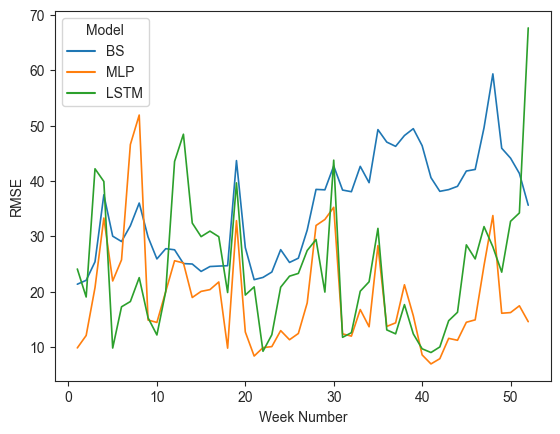

In [ ]:
import tensorflow as tf

#Date
df_options_agr = df_options
df_options_agr['Quote_date'] = pd.to_datetime(df_options_agr['Quote_date'])
df_options_agr['Week_number'] = df_options_agr['Quote_date'].dt.isocalendar().week

print(df_options_agr)


rmse_bs = df_options_agr.groupby(df_options_agr.Week_number).apply(lambda x : sqrt(tf.keras.metrics.mean_squared_error(x.Price, x.BS)))
rmse_bs = pd.DataFrame(rmse_bs)
rmse_bs.columns = ["BS"]

rmse_mlp = df_options_agr.groupby(df_options_agr.Week_number).apply(lambda x : sqrt(tf.keras.metrics.mean_squared_error(x.Price, x.MLP)))
rmse_mlp = pd.DataFrame(rmse_mlp)
rmse_mlp.columns = ["MLP"]


rmse_lstm = df_options_agr.groupby(df_options_agr.Week_number).apply(lambda x : sqrt(tf.keras.metrics.mean_squared_error(x.Price, x.LSTM)))
rmse_lstm = pd.DataFrame(rmse_lstm)
rmse_lstm.columns = ["LSTM"]

# Getting dataframe ready
rmse = pd.concat([rmse_bs, rmse_mlp, rmse_lstm], axis = 1)
rmse.reset_index(inplace=True)
rmse_m = rmse.melt("Week_number", var_name='Model', value_name='Errors')

# Plot
from scipy.ndimage.filters import gaussian_filter1d
from scipy import interpolate

sns.set_style("ticks")
sns.lineplot(x="Week_number", y="Errors", hue="Model", linewidth = 1.2,
             data=rmse_m)
plt.xlabel("Week Number")
plt.ylabel("RMSE")
plt.show()

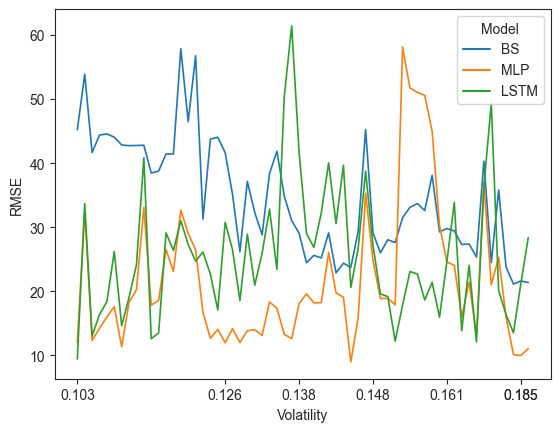

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#Volatility
df_options_agr = df_options
df_options_agr["Volatility_six"] = df_options_agr["Volatility"].map(lambda x: str(x)[:5])

rmse_bs = df_options_agr.groupby(df_options_agr.Volatility_six).apply(lambda x : sqrt(tf.keras.metrics.mean_squared_error(x.Price, x.BS)))
rmse_bs = pd.DataFrame(rmse_bs)
rmse_bs.columns = ["BS"]

rmse_mlp = df_options_agr.groupby(df_options_agr.Volatility_six).apply(lambda x : sqrt(tf.keras.metrics.mean_squared_error(x.Price, x.MLP)))
rmse_mlp = pd.DataFrame(rmse_mlp)
rmse_mlp.columns = ["MLP"]


rmse_lstm = df_options_agr.groupby(df_options_agr.Volatility_six).apply(lambda x : sqrt(tf.keras.metrics.mean_squared_error(x.Price, x.LSTM)))
rmse_lstm = pd.DataFrame(rmse_lstm)
rmse_lstm.columns = ["LSTM"]

# Getting dataframe ready
rmse = pd.concat([rmse_bs, rmse_mlp, rmse_lstm], axis = 1)
rmse.reset_index(inplace=True)
rmse_m = rmse.melt("Volatility_six", var_name='Model', value_name='Errors')

#Plot
sns.set_style("ticks")
g = sns.lineplot(x="Volatility_six", y="Errors", hue="Model", linewidth = 1.2,
             data=rmse_m)
sns.set_style("ticks")
plt.xlabel("Volatility")
plt.ylabel("RMSE")
plt.xticks([0,20,30,40,50,60,60])
plt.show()



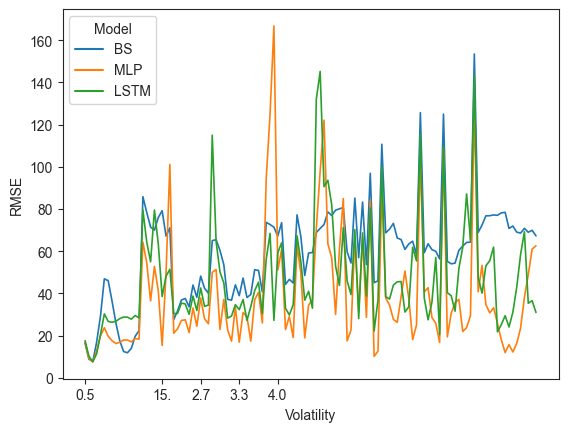

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#Moneyness
df_options_agr = df_options
df_options_agr["Moneyness"] = df_options_agr["Underlying_last"] / df_options_agr["Strike"]
df_options_arg = df_options_agr.loc[(df_options_agr["Moneyness"]>=0.5) & (df_options_agr["Moneyness"]<=5)]
df_options_agr["Moneyness_round"] = df_options_agr["Moneyness"].map(lambda x: str(x)[:3])

rmse_bs = df_options_agr.groupby(df_options_agr.Moneyness_round).apply(lambda x : sqrt(tf.keras.metrics.mean_squared_error(x.Price, x.BS)))
rmse_bs = pd.DataFrame(rmse_bs)
rmse_bs.columns = ["BS"]

rmse_mlp = df_options_agr.groupby(df_options_agr.Moneyness_round).apply(lambda x : sqrt(tf.keras.metrics.mean_squared_error(x.Price, x.MLP)))
rmse_mlp = pd.DataFrame(rmse_mlp)
rmse_mlp.columns = ["MLP"]


rmse_lstm = df_options_agr.groupby(df_options_agr.Moneyness_round).apply(lambda x : sqrt(tf.keras.metrics.mean_squared_error(x.Price, x.LSTM)))
rmse_lstm = pd.DataFrame(rmse_lstm)
rmse_lstm.columns = ["LSTM"]

# Getting dataframe ready
rmse = pd.concat([rmse_bs, rmse_mlp, rmse_lstm], axis = 1)
rmse.reset_index(inplace=True)
rmse_m = rmse.melt("Moneyness_round", var_name='Model', value_name='Errors')

#Plot
sns.set_style("ticks")
g = sns.lineplot(x="Moneyness_round", y="Errors", hue="Model", linewidth = 1.2,
             data=rmse_m)
sns.set_style("ticks")
plt.xlabel("Moneyness")
plt.ylabel("RMSE")
plt.xticks([0,20,30,40,50])
plt.show()

        Quote_date  Underlying_last  Strike   Ttl  Volatility     R     Price  \
0       2021-01-04          3701.38  1000.0     2    0.185353  0.09  2701.855   
1       2021-01-05          3727.05  1000.0     1    0.184968  0.08  2726.195   
2       2021-01-04          3701.38  1100.0     2    0.185353  0.09  2598.795   
3       2021-01-05          3727.05  1100.0     1    0.184968  0.08  2626.705   
4       2021-01-04          3701.38  1200.0     2    0.185353  0.09  2500.195   
...            ...              ...     ...   ...         ...   ...       ...   
1845477 2021-12-31          4766.39  9000.0  1085    0.136456  0.97   150.000   
1845478 2021-12-28          4787.26  9200.0  1088    0.138268  0.99     8.100   
1845479 2021-12-29          4792.94  9200.0  1087    0.138236  0.99     9.600   
1845480 2021-12-30          4779.28  9200.0  1086    0.137746  0.98     9.600   
1845481 2021-12-31          4766.39  9200.0  1085    0.136456  0.97   150.000   

                  BS       

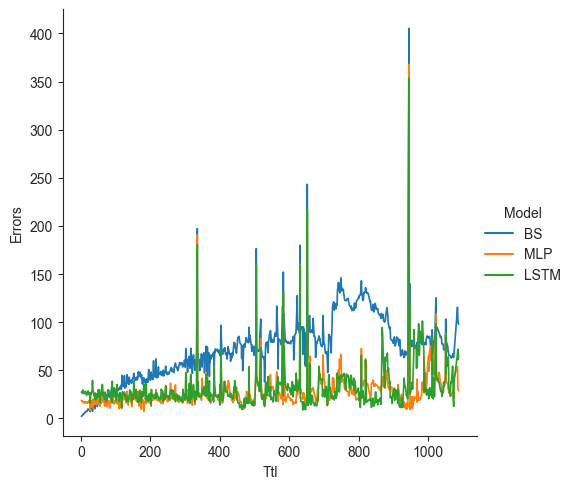

In [ ]:
import seaborn as sns

# Time to maturity
df_options_agr = df_options
#df_options_agr["Volatility_round"] = df_options_agr["Volatility"].astype(str).str[:4].astype(np.int64)
print(df_options_agr)

rmse_bs = df_options_agr.groupby(df_options_agr.Ttl).apply(lambda x : sqrt(tf.keras.metrics.mean_squared_error(x.Price, x.BS)))
rmse_bs = pd.DataFrame(rmse_bs)
rmse_bs.columns = ["BS"]

rmse_mlp = df_options_agr.groupby(df_options_agr.Ttl).apply(lambda x : sqrt(tf.keras.metrics.mean_squared_error(x.Price, x.MLP)))
rmse_mlp = pd.DataFrame(rmse_mlp)
rmse_mlp.columns = ["MLP"]


rmse_lstm = df_options_agr.groupby(df_options_agr.Ttl).apply(lambda x : sqrt(tf.keras.metrics.mean_squared_error(x.Price, x.LSTM)))
rmse_lstm = pd.DataFrame(rmse_lstm)
rmse_lstm.columns = ["LSTM"]

# Getting dataframe ready
rmse = pd.concat([rmse_bs, rmse_mlp, rmse_lstm], axis = 1)
rmse.reset_index(inplace=True)
rmse_m = rmse.melt("Ttl", var_name='Model', value_name='Errors')

#Plot
sns.set_style("ticks")
sns.relplot(x="Ttl", y="Errors", hue="Model", kind="line", linewidth = 1.2, data=rmse_m)

            BS        MLP       LSTM
Ttl                                 
30    7.010918  17.076417  26.522555
60   14.758414  17.509147  26.273374
90   23.023098  17.406696  24.810739
120  29.991160  18.915884  24.872955
150  37.410960  20.227485  23.470564
181  42.792914  20.970405  24.988526
216  41.922891  19.084080  23.167677
251  46.411061  20.983004  23.927750
286  51.488730  21.094084  23.920967
321  59.989047  26.882910  27.044772
356  64.150652  31.572892  30.919495
393  66.592683  26.455500  26.830703
435  69.038836  28.857280  27.890827
477  75.678258  20.600443  22.203359
519  82.692020  44.737329  42.962230
561  77.531200  29.176330  25.772233
603  86.634441  40.651079  46.450179
645  93.136487  38.401833  41.098146
687  96.044800  50.606382  47.960649
729  81.617450  32.820864  31.423923
    Time-to-maturity Model       RMSE
0               15.0    BS   7.010918
1               45.0    BS  14.758414
2               75.0    BS  23.023098
3              105.0    BS  29.991

<AxesSubplot:xlabel='Time-to-maturity', ylabel='RMSE'>

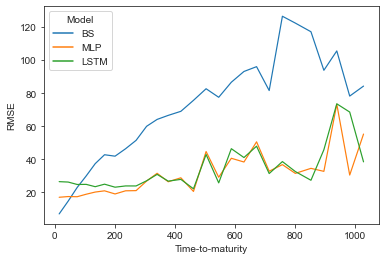

In [155]:
import seaborn as sns
import math

group = 30
models = ["BS", "MLP", "LSTM"]

df_options_agr = df_options

rmse_bs = df_options_agr.groupby(df_options_agr.Ttl).apply(lambda x : list(x.BS))
rmse_bs = pd.DataFrame(rmse_bs)
rmse_bs.columns = ["BS"]
rmse_bs_m = df_options_agr.groupby(df_options_agr.Ttl).apply(lambda x : list(x.MLP))
rmse_bs["MLP"] = rmse_bs_m
rmse_bs_l = df_options_agr.groupby(df_options_agr.Ttl).apply(lambda x : list(x.LSTM))
rmse_bs["LSTM"] = rmse_bs_l
rmse_bs_p = df_options_agr.groupby(df_options_agr.Ttl).apply(lambda x : list(x.Price))
rmse_bs["Price"] = rmse_bs_p

for i in range(group):
    rmse_bs[f"Price-{i}"] = rmse_bs["Price"].shift(i)
    for model in models:
        rmse_bs[f"{model}-{i}"] = rmse_bs[model].shift(i)

rmse_bs = rmse_bs.dropna()
rmse_bs = rmse_bs.iloc[::group]

rmse_bs["Price_combined"] = rmse_bs[[f"Price-{i}" for i in range(group)]].values.tolist()
rmse_bs["Price_combined"] = rmse_bs["Price_combined"].apply(lambda x: [item for sublist in x for item in sublist])
for model in models:
    rmse_bs[f"{model}_combined"] = rmse_bs[[f"{model}-{i}" for i in range(group)]].values.tolist()
    rmse_bs[f"{model}_combined"] = rmse_bs[f"{model}_combined"].apply(lambda x: [item for sublist in x for item in sublist])

for model in models:
    rmse_bs[f"{model}"] = rmse_bs[[f"{model}_combined", "Price_combined"]].values.tolist()
    rmse_bs[f"{model}"] = rmse_bs[f"{model}"].apply(lambda x : sqrt(tf.keras.metrics.mean_squared_error(x[0], x[1])))

rmse_bs = rmse_bs[models]

print(rmse_bs.head(20))

rmse = pd.DataFrame(rmse_bs)

rmse.reset_index(inplace=True)
rmse_m = rmse.melt("Ttl", var_name='Model', value_name='RMSE')
rmse_m["Ttl"] -= group/2

rmse_m = rmse_m.rename(columns={"Ttl" : "Time-to-maturity"})

print(rmse_m)

#Plot
sns.set_style("ticks")
sns.lineplot(x="Time-to-maturity", y="RMSE", hue="Model", linewidth = 1.2, data=rmse_m)


                   BS        MLP       LSTM
Volatility                                 
0.105274    51.525695  26.614537  26.607503
0.106177    40.644955  11.473132  13.329822
0.106859    43.873799  14.193948  16.964974
0.107543    44.254790  14.805920  18.571423
0.107975    46.061339  17.722088  19.159089
0.108839    42.006106  15.569883  22.758777
0.109455    41.734562  13.983798  17.412584
0.109835    45.039910   9.803339  10.361593
0.110167    43.346247  22.874039  25.877079
0.110366    40.739574   9.909173  14.923538
0.111069    44.123750  15.678010  20.832237
0.111460    45.219895  27.857033  28.650520
0.112069    43.551501  25.561326  32.092088
0.113316    39.347979  31.569816  31.293414
0.113917    38.031908   7.991490  11.380168
0.114305    38.494516   8.931905  11.929391
0.115180    38.270282  21.608699  15.229558
0.115815    42.161055  28.583551  31.364051
0.119766    55.846463  31.021979  29.359411
0.122466    44.197002  25.312622  27.277322
     Volatility Model       RMSE

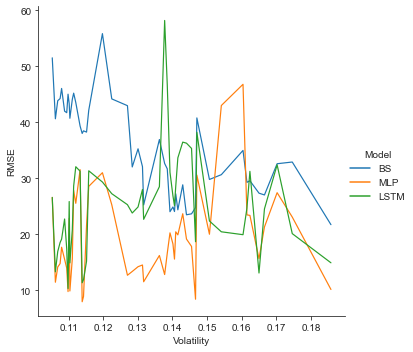

In [144]:
import seaborn as sns

group = 5
models = ["BS", "MLP", "LSTM"]

df_options_agr = df_options

rmse_bs = df_options_agr.groupby(df_options_agr.Volatility).apply(lambda x : list(x.BS))
rmse_bs = pd.DataFrame(rmse_bs)
rmse_bs.columns = ["BS"]
rmse_bs_m = df_options_agr.groupby(df_options_agr.Volatility).apply(lambda x : list(x.MLP))
rmse_bs["MLP"] = rmse_bs_m
rmse_bs_l = df_options_agr.groupby(df_options_agr.Volatility).apply(lambda x : list(x.LSTM))
rmse_bs["LSTM"] = rmse_bs_l
rmse_bs_p = df_options_agr.groupby(df_options_agr.Volatility).apply(lambda x : list(x.Price))
rmse_bs["Price"] = rmse_bs_p

for i in range(group):
    rmse_bs[f"Price-{i}"] = rmse_bs["Price"].shift(i)
    for model in models:
        rmse_bs[f"{model}-{i}"] = rmse_bs[model].shift(i)

rmse_bs = rmse_bs.dropna()
rmse_bs = rmse_bs.iloc[::group]

rmse_bs["Price_combined"] = rmse_bs[[f"Price-{i}" for i in range(group)]].values.tolist()
rmse_bs["Price_combined"] = rmse_bs["Price_combined"].apply(lambda x: [item for sublist in x for item in sublist])
for model in models:
    rmse_bs[f"{model}_combined"] = rmse_bs[[f"{model}-{i}" for i in range(group)]].values.tolist()
    rmse_bs[f"{model}_combined"] = rmse_bs[f"{model}_combined"].apply(lambda x: [item for sublist in x for item in sublist])

for model in models:
    rmse_bs[f"{model}"] = rmse_bs[[f"{model}_combined", "Price_combined"]].values.tolist()
    rmse_bs[f"{model}"] = rmse_bs[f"{model}"].apply(lambda x : sqrt(tf.keras.metrics.mean_squared_error(x[0], x[1])))

rmse_bs = rmse_bs[models]

print(rmse_bs.head(20))

rmse = pd.DataFrame(rmse_bs)

rmse.reset_index(inplace=True)
rmse_m = rmse.melt("Volatility", var_name='Model', value_name='RMSE')
#rmse_m["Volatility"] -= group/2

#rmse_m = rmse_m.rename(columns={"Ttl" : "Time-to-maturity"})

print(rmse_m)

#Plot
sns.set_style("ticks")
sns.relplot(x="Volatility", y="RMSE", hue="Model", kind="line", linewidth = 1.2, data=rmse_m)


                  BS        MLP       LSTM
Moneyness                                 
0.614862   13.871116  14.478654  14.960384
0.653855   10.979249  11.525627  12.446802
0.698138    7.643232   7.946127   9.210721
0.748670    7.131609   7.306694   7.661595
0.807180    8.336149   7.787663   7.532618
0.854441   12.900674  10.051577   9.618050
0.879875   17.420612  13.426579  11.970246
0.895149   19.923686  14.967394  12.772763
0.906558   21.709785  15.586819  13.049791
0.915076   22.360481  15.482954  13.003164
0.921702   23.453711  16.250112  13.725544
0.927679   23.391016  16.086913  13.604261
0.933044   23.306866  16.173951  13.970872
0.937953   24.342195  16.662851  14.198057
0.942555   25.165821  16.919580  14.621565
0.947030   25.844611  17.357675  15.268022
0.951487   25.730073  17.498838  15.690161
0.955871   26.729515  17.965974  16.384012
0.960290   27.704665  18.646614  17.481964
0.964749   28.482140  19.352232  18.334559
     Moneyness Model       RMSE
0     0.614862    BS  

<AxesSubplot:xlabel='Moneyness', ylabel='RMSE'>

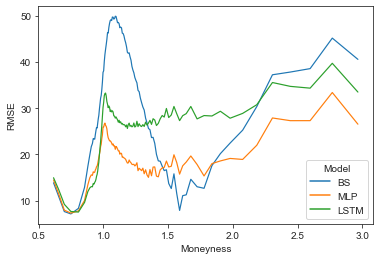

In [157]:
import seaborn as sns

group = 1000
models = ["BS", "MLP", "LSTM"]

df_options_agr = df_options

df_options_agr["Moneyness"] = df_options_agr["Underlying_last"] / df_options_agr["Strike"]

df_options_agr = df_options_agr[(df_options_agr["Moneyness"] >= 0.5) & (df_options_agr["Moneyness"] <= 3)]

rmse_bs = df_options_agr.groupby(df_options_agr.Moneyness).apply(lambda x : list(x.BS))
rmse_bs = pd.DataFrame(rmse_bs)
rmse_bs.columns = ["BS"]
rmse_bs_m = df_options_agr.groupby(df_options_agr.Moneyness).apply(lambda x : list(x.MLP))
rmse_bs["MLP"] = rmse_bs_m
rmse_bs_l = df_options_agr.groupby(df_options_agr.Moneyness).apply(lambda x : list(x.LSTM))
rmse_bs["LSTM"] = rmse_bs_l
rmse_bs_p = df_options_agr.groupby(df_options_agr.Moneyness).apply(lambda x : list(x.Price))
rmse_bs["Price"] = rmse_bs_p

for i in range(group):
    rmse_bs[f"Price-{i}"] = rmse_bs["Price"].shift(i)
    for model in models:
        rmse_bs[f"{model}-{i}"] = rmse_bs[model].shift(i)

rmse_bs = rmse_bs.dropna()
rmse_bs = rmse_bs.iloc[::group]

rmse_bs["Price_combined"] = rmse_bs[[f"Price-{i}" for i in range(group)]].values.tolist()
rmse_bs["Price_combined"] = rmse_bs["Price_combined"].apply(lambda x: [item for sublist in x for item in sublist])
for model in models:
    rmse_bs[f"{model}_combined"] = rmse_bs[[f"{model}-{i}" for i in range(group)]].values.tolist()
    rmse_bs[f"{model}_combined"] = rmse_bs[f"{model}_combined"].apply(lambda x: [item for sublist in x for item in sublist])

for model in models:
    rmse_bs[f"{model}"] = rmse_bs[[f"{model}_combined", "Price_combined"]].values.tolist()
    rmse_bs[f"{model}"] = rmse_bs[f"{model}"].apply(lambda x : sqrt(tf.keras.metrics.mean_squared_error(x[0], x[1])))

rmse_bs = rmse_bs[models]

print(rmse_bs.head(20))

rmse = pd.DataFrame(rmse_bs)

rmse.reset_index(inplace=True)
rmse_m = rmse.melt("Moneyness", var_name='Model', value_name='RMSE')
#rmse_m["Volatility"] -= group/2

#rmse_m = rmse_m.rename(columns={"Ttl" : "Time-to-maturity"})

print(rmse_m)

#Plot
sns.set_style("ticks")
sns.lineplot(x="Moneyness", y="RMSE", hue="Model",  linewidth = 1.2, data=rmse_m)


<ipython-input-176-4e51e8e72d4e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_options_agr['Moneyness'] = df_options_agr['Moneyness'].apply(lambda x: np.floor(x*20)/20)


                  BS        MLP       LSTM
Moneyness                                 
0.80       12.106856   9.706478   9.265877
0.85       18.953509  14.217978  12.351779
0.90       23.899275  16.398386  14.087784
0.95       32.266121  21.908574  23.643482
1.00       44.643396  25.048041  31.603597
1.05       49.433248  22.073650  28.771818
1.10       47.943145  20.461328  27.067556
1.15       43.483248  18.697401  26.270707
1.20       16.854371  19.329622  21.143072
    Moneyness Model       RMSE
0        0.80    BS  12.106856
1        0.85    BS  18.953509
2        0.90    BS  23.899275
3        0.95    BS  32.266121
4        1.00    BS  44.643396
5        1.05    BS  49.433248
6        1.10    BS  47.943145
7        1.15    BS  43.483248
8        1.20    BS  16.854371
9        0.80   MLP   9.706478
10       0.85   MLP  14.217978
11       0.90   MLP  16.398386
12       0.95   MLP  21.908574
13       1.00   MLP  25.048041
14       1.05   MLP  22.073650
15       1.10   MLP  20.461328


<AxesSubplot:xlabel='Moneyness', ylabel='RMSE'>

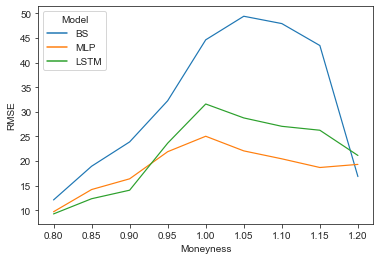

In [176]:
import seaborn as sns

models = ["BS", "MLP", "LSTM"]

df_options_agr = df_options

df_options_agr["Moneyness"] = df_options_agr["Underlying_last"] / df_options_agr["Strike"]

df_options_agr = df_options_agr[(df_options_agr["Moneyness"] >= 0.8) & (df_options_agr["Moneyness"] <= 1.2)]

df_options_agr['Moneyness'] = df_options_agr['Moneyness'].apply(lambda x: np.floor(x*20)/20)

rmse_bs = df_options_agr.groupby(df_options_agr.Moneyness).apply(lambda x : list(x.BS))
rmse_bs = pd.DataFrame(rmse_bs)
rmse_bs.columns = ["BS"]
rmse_bs_m = df_options_agr.groupby(df_options_agr.Moneyness).apply(lambda x : list(x.MLP))
rmse_bs["MLP"] = rmse_bs_m
rmse_bs_l = df_options_agr.groupby(df_options_agr.Moneyness).apply(lambda x : list(x.LSTM))
rmse_bs["LSTM"] = rmse_bs_l
rmse_bs_p = df_options_agr.groupby(df_options_agr.Moneyness).apply(lambda x : list(x.Price))
rmse_bs["Price"] = rmse_bs_p

for model in models:
    rmse_bs[f"{model}"] = rmse_bs[[f"{model}", "Price"]].values.tolist()
    rmse_bs[f"{model}"] = rmse_bs[f"{model}"].apply(lambda x : sqrt(tf.keras.metrics.mean_squared_error(x[0], x[1])))

rmse_bs = rmse_bs[models]

print(rmse_bs.head(20))

rmse = pd.DataFrame(rmse_bs)

rmse.reset_index(inplace=True)
rmse_m = rmse.melt("Moneyness", var_name='Model', value_name='RMSE')
#rmse_m["Volatility"] -= group/2

#rmse_m = rmse_m.rename(columns={"Ttl" : "Time-to-maturity"})

print(rmse_m)

#Plot
sns.set_style("ticks")
sns.lineplot(x="Moneyness", y="RMSE", hue="Model",  linewidth = 1.2, data=rmse_m)


                   BS        MLP       LSTM
Quote_date                                 
2021-01-15  21.735804  11.065967  21.702804
2021-02-01  33.145581  27.712989  39.016047
2021-02-16  28.937636  26.493945  14.455475
2021-03-03  33.299668  42.938285  19.723112
2021-03-17  27.028650  16.387018  13.711285
2021-03-31  27.215702  25.693557  44.356031
2021-04-15  24.360264  18.964095  30.350400
2021-04-29  24.338807  21.045685  30.541366
2021-05-13  30.332019  18.130110  27.375173
2021-05-27  31.793246  20.505166  26.213640
2021-06-11  22.912113   9.916579  13.046405
2021-06-25  26.445269  12.170653  21.889089
2021-07-12  28.920383  15.774783  25.984916
2021-07-26  38.891080  33.070404  25.666275
2021-08-10  40.585892  25.134369  30.017673
2021-08-24  40.722376  14.821913  19.521876
2021-09-13  45.885291  20.894521  23.556614
2021-09-28  47.575682  18.604988  15.303065
2021-10-13  46.981003  10.705612  10.501964
2021-10-27  38.264349   8.475643  11.658535
   Quote date Model       RMSE
0

<AxesSubplot:xlabel='Quote date', ylabel='RMSE'>

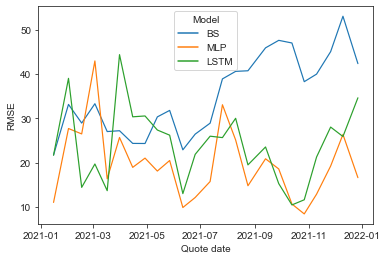

In [142]:
import seaborn as sns

group = 10
models = ["BS", "MLP", "LSTM"]

df_options_agr = df_options

rmse_bs = df_options_agr.groupby(df_options_agr.Quote_date).apply(lambda x : list(x.BS))
rmse_bs = pd.DataFrame(rmse_bs)
rmse_bs.columns = ["BS"]
rmse_bs_m = df_options_agr.groupby(df_options_agr.Quote_date).apply(lambda x : list(x.MLP))
rmse_bs["MLP"] = rmse_bs_m
rmse_bs_l = df_options_agr.groupby(df_options_agr.Quote_date).apply(lambda x : list(x.LSTM))
rmse_bs["LSTM"] = rmse_bs_l
rmse_bs_p = df_options_agr.groupby(df_options_agr.Quote_date).apply(lambda x : list(x.Price))
rmse_bs["Price"] = rmse_bs_p

for i in range(group):
    rmse_bs[f"Price-{i}"] = rmse_bs["Price"].shift(i)
    for model in models:
        rmse_bs[f"{model}-{i}"] = rmse_bs[model].shift(i)

rmse_bs = rmse_bs.dropna()
rmse_bs = rmse_bs.iloc[::group]

rmse_bs["Price_combined"] = rmse_bs[[f"Price-{i}" for i in range(group)]].values.tolist()
rmse_bs["Price_combined"] = rmse_bs["Price_combined"].apply(lambda x: [item for sublist in x for item in sublist])
for model in models:
    rmse_bs[f"{model}_combined"] = rmse_bs[[f"{model}-{i}" for i in range(group)]].values.tolist()
    rmse_bs[f"{model}_combined"] = rmse_bs[f"{model}_combined"].apply(lambda x: [item for sublist in x for item in sublist])

for model in models:
    rmse_bs[f"{model}"] = rmse_bs[[f"{model}_combined", "Price_combined"]].values.tolist()
    rmse_bs[f"{model}"] = rmse_bs[f"{model}"].apply(lambda x : sqrt(tf.keras.metrics.mean_squared_error(x[0], x[1])))

rmse_bs = rmse_bs[models]

print(rmse_bs.head(20))

rmse = pd.DataFrame(rmse_bs)

rmse.reset_index(inplace=True)
rmse_m = rmse.melt("Quote_date", var_name='Model', value_name='RMSE')
#rmse_m["Volatility"] -= group/2
rmse_m['Quote_date'] = pd.to_datetime(rmse_m['Quote_date'])
rmse_m = rmse_m.rename(columns={"Quote_date" : "Quote date"})

print(rmse_m)

#Plot
sns.set_style("ticks")
sns.lineplot(x="Quote date", y="RMSE", hue="Model",  linewidth = 1.2, data=rmse_m)


<ipython-input-182-88c38f0b4bfe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rmse_bs['Quote_date'] = pd.to_datetime(rmse_bs['Quote_date'])


<AxesSubplot:xlabel='Quote date', ylabel='S&P500'>

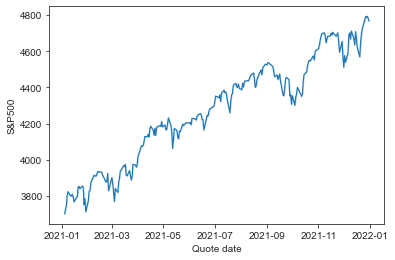

In [182]:
import seaborn as sns

group = 1
models = ["BS", "MLP", "LSTM"]

rmse_bs = df_options
rmse_bs = rmse_bs[["Quote_date", "Underlying_last"]]
rmse_bs['Quote_date'] = pd.to_datetime(rmse_bs['Quote_date'])
rmse_bs = rmse_bs.rename(columns={"Quote_date" : "Quote date", "Underlying_last" : "S&P500"})

#Plot
sns.set_style("ticks")
sns.lineplot(x="Quote date", y="S&P500", linewidth = 1.2, data=rmse_bs)


In [154]:
import seaborn as sns

group = 400
models = ["BS", "MLP", "LSTM"]

df_options_agr = df_options

df_options_agr["Moneyness"] = df_options_agr["Underlying_last"] / df_options_agr["Strike"]

rmse_bs = df_options_agr[["Ttl", "Moneyness"] + models]

rmse = pd.DataFrame(rmse_bs)

rmse_m = rmse.melt(["Moneyness", "Ttl"], var_name='Model', value_name='RMSE', value_vars = models)

sns.relplot(x="Ttl", y="Moneyness", hue="Model", size="RMSE",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=rmse_m)




    Ttl  Moneyness           BS        MLP       LSTM
0     2   3.701380  2701.384931  2692.4382  2714.8896
1     1   3.727050  2727.052192  2717.7556  2731.6880
2     2   3.364891  2601.385425  2593.0208  2615.4146
3     1   3.388227  2627.052411  2618.3533  2632.6520
4     2   3.084483  2501.385918  2493.7195  2515.3680
5     1   3.105875  2527.052630  2518.9358  2532.5933
6     2   2.847215  2401.386411  2395.0862  2415.0030
7     1   2.866962  2427.052849  2419.6453  2432.5898
8     2   2.643843  2301.386904  2296.5280  2314.8135
9     1   2.662179  2327.053068  2321.0122  2332.7310
10    2   2.467587  2201.387397  2198.0215  2214.3706
11    1   2.484700  2227.053288  2222.3630  2232.6318
12    2   2.313363  2101.387890  2098.8613  2114.0796
13    1   2.329406  2127.053507  2123.2783  2132.4380
14    2   2.177282  2001.388384  1999.6240  2013.5522
15    1   2.192382  2027.053726  2024.0413  2032.1340
16    2   2.056322  1901.388877  1900.3868  1913.1205
17    1   2.070583  1927.053

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000002B302D67280> (for post_execute):


KeyboardInterrupt: 

<ipython-input-198-633e5b9451b7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_options_agr['Volatility'] = df_options_agr['Volatility'].apply(lambda x: np.floor(x*250)/250)


                   BS        MLP       LSTM
Volatility                                 
0.100       28.428982  11.412098  11.278279
0.108       26.253894  18.213841  11.226234
0.120       22.056454  14.136423  13.334310
0.128       14.440644   9.865018  16.505753
0.140       10.821500  13.793496  16.817355
0.148       16.163694  19.629968   9.266468
0.160       11.038930  18.102541  13.911820
0.168       11.778515  19.401400  14.520012
0.180       16.802583   9.308458  10.212751
    Volatility Model       RMSE
0        0.100    BS  28.428982
1        0.108    BS  26.253894
2        0.120    BS  22.056454
3        0.128    BS  14.440644
4        0.140    BS  10.821500
5        0.148    BS  16.163694
6        0.160    BS  11.038930
7        0.168    BS  11.778515
8        0.180    BS  16.802583
9        0.100   MLP  11.412098
10       0.108   MLP  18.213841
11       0.120   MLP  14.136423
12       0.128   MLP   9.865018
13       0.140   MLP  13.793496
14       0.148   MLP  19.629968
15  

<AxesSubplot:xlabel='Volatility', ylabel='RMSE'>

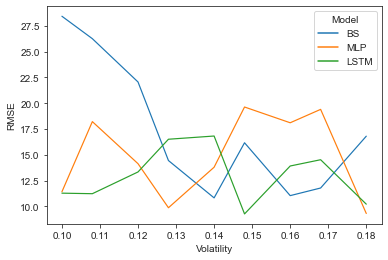

In [198]:
import seaborn as sns

models = ["BS", "MLP", "LSTM"]

df_options_agr = df_options

df_options_agr["Moneyness"] = df_options_agr["Underlying_last"] / df_options_agr["Strike"]

df_options_agr = df_options_agr[(df_options_agr["Moneyness"] <= 0.97)]


df_options_agr['Volatility'] = df_options_agr['Volatility'].apply(lambda x: np.floor(x*250)/250)

rmse_bs = df_options_agr.groupby(df_options_agr.Volatility).apply(lambda x : list(x.BS))
rmse_bs = pd.DataFrame(rmse_bs)
rmse_bs.columns = ["BS"]
rmse_bs_m = df_options_agr.groupby(df_options_agr.Volatility).apply(lambda x : list(x.MLP))
rmse_bs["MLP"] = rmse_bs_m
rmse_bs_l = df_options_agr.groupby(df_options_agr.Volatility).apply(lambda x : list(x.LSTM))
rmse_bs["LSTM"] = rmse_bs_l
rmse_bs_p = df_options_agr.groupby(df_options_agr.Volatility).apply(lambda x : list(x.Price))
rmse_bs["Price"] = rmse_bs_p

for model in models:
    rmse_bs[f"{model}"] = rmse_bs[[f"{model}", "Price"]].values.tolist()
    rmse_bs[f"{model}"] = rmse_bs[f"{model}"].apply(lambda x : sqrt(tf.keras.metrics.mean_squared_error(x[0], x[1])))

rmse_bs = rmse_bs[models]

print(rmse_bs.head(20))

rmse = pd.DataFrame(rmse_bs)

rmse.reset_index(inplace=True)
rmse_m = rmse.melt("Volatility", var_name='Model', value_name='RMSE')
#rmse_m["Volatility"] -= group/2

#rmse_m = rmse_m.rename(columns={"Ttl" : "Time-to-maturity"})

print(rmse_m)

#Plot
sns.set_style("ticks")
sns.lineplot(x="Volatility", y="RMSE", hue="Model",  linewidth = 1.2, data=rmse_m)
